In [1]:
#!sudo pip3 install pyro-ppl -q
import pyro.distributions as dist
from pyro import plate
from pyro.distributions import Categorical
import pyro
import torch.nn as nn
import torch
import torch.distributions.constraints as constraints
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from spotlight.evaluation import sequence_mrr_score
import matplotlib.pyplot as plt
import numpy as np
def get_device(device = None):
    if device is not None:
        return torch.device(device)
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return device
device = get_device("cuda")

In [2]:
dataset = "generated"
if dataset == "rsc":
    ##RCS DATA##
    from preproc import preprocess_rsc15
    dat, dat_seq , ind2val = preprocess_rsc15(density_value = None, limit_train = 200000, limit_test = None)
        
elif dataset == "generated":
    ## GENERATED DATA ##
    from preproc import preprocess_generated
    dat, dat_seq, ind2val = preprocess_generated()

# GENERATE A SMALLER TRAINING SET FOR METRIC TESTING
dat_seq = {name : torch.tensor(dat_seq[name].sequences).long().to(device) for name in ['train','test']}
dat_seq['train_small'] = dat_seq['train'][torch.randint(len(dat_seq['train']), (10000,))]

In [3]:
class LSTMrec(nn.Module):
    def __init__(self, num_items, emb_dim, device):
        super(LSTMrec, self).__init__()
        self.num_items = num_items
        self.emb_dim = emb_dim
        
        ### CUDA
        self.device = device
        
        # ITEM EMB
        #self.V = pyro.param("Vpar", torch.rand(self.num_items, self.emb_dim).to(self.device)-0.5)
        self.V = nn.Embedding(embedding_dim= self.emb_dim,
                                           num_embeddings = self.num_items)
        #self.V = pyro.param("V", V.weight)
        
        ### LSTM
        self.linear = nn.Linear(1,1) #nn.ModuleList(nn.Parameter(torch.zeros((1,))))
        self.lstm = nn.LSTM(batch_first=True,
                                input_size=self.emb_dim,
                                hidden_size=self.emb_dim)
        
        # Need to permute before and after LSTM because LSTM's batch_first is not supported...
        self.permute_for_lstm = lambda x: x.permute(1,0,2)
        self.permute_back_lstm = lambda x: x.permute(1,0,2)
        
        if device.type == "cuda":
            self.cuda()    
    def forward(self, seq):
        """
        seq: a torch array with dimension (batch_size, sequence length).
        Needs to be long() and on right device. 
        
        Outputs log probabilities of all items. (todo: Let user specify which items to calc)
        """
        x_vecs = self.V(seq)
        z, _ = self.lstm(x_vecs)
        
        
        lprob = self.linear.bias + z.matmul(self.V.weight.t())
        return lprob
    
    def model(self, seq):
        bias = dist.Normal(0,1)
        mu0 = torch.zeros(self.emb_dim).to(self.device)
        var0 = torch.diag(torch.ones(self.emb_dim).to(self.device)*3)

        muV = pyro.sample("muV", dist.MultivariateNormal(loc = mu0, covariance_matrix= var0))

        with plate("item_loop", self.num_items):
            V = pyro.sample(f"V", dist.MultivariateNormal(muV, var0))

        # LIFT MODULE:
        prior = {'linear.bias' : bias,
                'V.weight' : Deterministic_distr(V)}
        lifted_module = pyro.random_module("net", self, prior= prior)
        

        lifted_reg_model = lifted_module()
        lifted_reg_model.lstm.flatten_parameters()

        with pyro.plate("data", len(seq), subsample_size=50) as ind:
            batch_seq = seq[ind,]
            batch_mask = (batch_seq!=0).float()

            lprobs = lifted_reg_model(batch_seq)
            data = pyro.sample("obs_x", 
                               dist.Categorical(logits=lprobs).mask(batch_mask).to_event(2), 
                               obs = batch_seq)
        return lifted_reg_model
    
    def guide(self, x):
                           
        bias_loc = pyro.param("bias_loc", torch.tensor(0.0).to(device))
        bias_scale = pyro.param("bias_scale", torch.tensor(2.0).to(device), constraint = constraints.positive)
        bias = dist.Normal(loc = bias_loc, scale = bias_scale)

        
        # GLOBAL V:
        muV_mean = pyro.param("muV_mean", torch.rand(self.emb_dim).to(self.device))
        global_triV = pyro.param("triangVpar", 
              torch.diag(0.5*torch.ones(self.emb_dim)).to(self.device), 
              constraint = constraints.lower_cholesky)
        muV = pyro.sample("muV", dist.MultivariateNormal(muV_mean, scale_tril=global_triV))
        
        ### ITEMS RVs ###
        # Each item has a factor it multiplies L with on diagonal. Inspiration: covar = L D L^t = (L D^0.5) (L D^0.5)ˆt
        # item_var is the D**2
        item_var = pyro.param("item_var_factor", (torch.rand(self.num_items)+0.5).to(device),
                              constraint = constraints.positive)
        D_V = torch.diag(torch.ones(self.emb_dim).to(device)).unsqueeze(0).repeat(len(item_var),1,1)*item_var.unsqueeze(1).unsqueeze(1)
        triV = global_triV.matmul(D_V)

        V = pyro.param("Vpar", torch.rand(self.num_items, self.emb_dim).to(self.device)-0.5)

        ## item latent vectors
        with plate("item_loop", self.num_items) as i:
            V = pyro.sample(f"V", dist.MultivariateNormal(V[i,], scale_tril=triV[i,]))
            
        posterior = {'linear.bias' : bias,
                'V.weight' : Deterministic_distr(V)}
        
        lifted_module = pyro.random_module("net", self, prior = posterior)
        
        lifted_reg_model = lifted_module()
        lifted_reg_model.lstm.flatten_parameters()
        return lifted_reg_model

    
class Deterministic_distr(pyro.distributions.Distribution):
    def __init__(self, V):
        self.V = V
    def sample(self):
        return self.V
    def log_prob(self,x):
        return torch.zeros(x.size()[0])
    

In [4]:
def compute_hitrate(seq, num_recs = 20, tau = 6):
    posterior_predictive = seqrec.guide(seq)
    feature_seq = seq[:,:tau]
    test_seq = seq[:,tau:]
    
    lprob = posterior_predictive(feature_seq)
    topK = lprob.argsort(dim=2, descending=True)[:,-1,:num_recs]

    hitrate = torch.tensor(0.0)
    totrate = torch.tensor(0.0)
    for i in range(len(seq)):
        hitmatrix = topK[i].unsqueeze(1) == test_seq[i].unsqueeze(0)
        hitrate += hitmatrix.sum()
        totrate += (test_seq[i] != 0).sum()
        
    return (hitrate/totrate).item()

def unique_not_sort(x):
    """
    torch.unique is sorting on gpu whatever the input. This is a workaround.
    https://discuss.pytorch.org/t/is-it-a-bug-for-torch-unique-on-gpu/33095/5
    """
    x_unique = torch.unique(x, sorted=True)
    x_idx = (torch.cat([(x==x_u).nonzero()[0] for x_u in x_unique])).sort()[0]
    return x[x_idx]

def unique_via_cpu(x, device):
    return torch.unique(x.cpu(), sorted=False).to(device)

In [5]:
def torch_unique_ordered(seq, K, device):
    return torch.tensor(numpy_unique_ordered(seq.cpu().numpy())[:K]).to(device)

def numpy_unique_ordered(seq):
    """Remove duplicate from a list while keeping order with Numpy.unique
    Required:
        seq: A list containing all items
    Returns:
        A list with only unique values. Only the first occurence is kept.
    """
    array_unique = np.unique(seq, return_index=True)
    dstack = np.dstack(array_unique)
    dstack.dtype = np.dtype([('v', dstack.dtype), ('i', dstack.dtype)])
    dstack.sort(order='i', axis=1)
    return dstack.flatten()['v']#.tolist()

In [6]:
def compute_bayesian_hitrate(seq, num_recs = 20, tau = 6, num_samples = None):
    feature_seq = seq[:,:tau]
    test_seq = seq[:,tau:]
    
    if num_samples is None:
        num_samples = num_recs
    # SAMPLE ALL POSTERIORS
    topK_samples = []
    for i in range(num_samples):
        posterior_predictive = seqrec.guide(feature_seq)
        pp = posterior_predictive(feature_seq)[:,-1]
        topK = pp.argsort(dim=1, descending=True)[:,:num_recs] # swap with torch.topk
        topK_samples.append(topK.unsqueeze(2))

    all_recs = torch.cat(topK_samples,2) # dim : (batch, topK, samples)
    # sum up across users:
    hitrate = torch.tensor(0.0)
    totrate = torch.tensor(0.0)
    misrate = torch.tensor(0.0)
    for i in range(len(seq)):
        onerec = all_recs[i,]
        recs = torch_unique_ordered(onerec.flatten(), K = num_recs, device = device)
        hitmatrix = recs.unsqueeze(1) == test_seq[i].unsqueeze(0)
        misrate += num_recs - len(recs)
        hitrate += hitmatrix.sum()
        totrate += (test_seq[i] != 0).sum() # all that are not the padding index count
    if misrate > 0:
        print("Found positive misrate!")
        print(hitrate, totrate, misrate)
    return (hitrate/totrate).item() #, all_recs, test_seq

In [7]:
print("Initializing model")
pyro.clear_param_store()
seqrec = LSTMrec(len(ind2val['itemId'])+1, emb_dim = 4, device = device)
seqrec

Initializing model


LSTMrec(
  (V): Embedding(1000, 4)
  (linear): Linear(in_features=1, out_features=1, bias=True)
  (lstm): LSTM(4, 4, batch_first=True)
)

step: 0 	 loss: 2798213 	 TRAIN hitrate: freq/bayes: 0.0124 / 0.0105  	 TEST hitrate: freq/bayes: 0.0159 / 0.0073
step: 50 	 loss: 2203538 	 TRAIN hitrate: freq/bayes: 0.0338 / 0.0396  	 TEST hitrate: freq/bayes: 0.0110 / 0.0110
step: 100 	 loss: 1858235 	 TRAIN hitrate: freq/bayes: 0.0638 / 0.0553  	 TEST hitrate: freq/bayes: 0.0306 / 0.0294
step: 150 	 loss: 1777156 	 TRAIN hitrate: freq/bayes: 0.0677 / 0.0651  	 TEST hitrate: freq/bayes: 0.0404 / 0.0367
step: 200 	 loss: 1664335 	 TRAIN hitrate: freq/bayes: 0.0808 / 0.0777  	 TEST hitrate: freq/bayes: 0.0526 / 0.0453
step: 250 	 loss: 1622818 	 TRAIN hitrate: freq/bayes: 0.0802 / 0.0784  	 TEST hitrate: freq/bayes: 0.0514 / 0.0514
step: 300 	 loss: 1541739 	 TRAIN hitrate: freq/bayes: 0.0816 / 0.0817  	 TEST hitrate: freq/bayes: 0.0490 / 0.0490
step: 350 	 loss: 1478322 	 TRAIN hitrate: freq/bayes: 0.0890 / 0.0881  	 TEST hitrate: freq/bayes: 0.0428 / 0.0453
step: 400 	 loss: 1675619 	 TRAIN hitrate: freq/bayes: 0.0728 / 0.0667  	 T

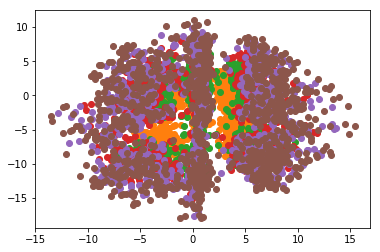

In [8]:
%%time
n_steps = 1001
num_recs = 10
pyro.clear_param_store()

# set up the optimizer
adam_params = {"lr": 0.1}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(seqrec.model, seqrec.guide, optimizer, loss=Trace_ELBO())

imgs = []
# do gradient steps
for step in range(n_steps):
    loss = svi.step(dat_seq['train'])

    if step%50== 0:
        # RMSE
        hitrate_train = compute_bayesian_hitrate(dat_seq['train_small'], num_recs = num_recs, num_samples=1)
        hitrate_test = compute_bayesian_hitrate(dat_seq['test'], num_recs = num_recs, num_samples=1)
        bayeshit_train = compute_bayesian_hitrate(dat_seq['train_small'], num_recs = num_recs, num_samples=3)
        bayeshit_test = compute_bayesian_hitrate(dat_seq['test'], num_recs = num_recs, num_samples=3)
        print(f"step: {step} \t loss: {loss:.0f} \t TRAIN hitrate: freq/bayes: {hitrate_train:.3f} / {bayeshit_train:.3f}  \t TEST hitrate: freq/bayes: {hitrate_test:.3f} / {bayeshit_test:.3f}")
    if step%200==0:
        V = pyro.param("Vpar").detach().cpu().numpy()
        img = plt.plot(V[:,0], V[:,1], "o", animated=True)
        imgs.append(img[0])
        #plt.show()

## Plot distribution of items

In [9]:
def plot_distr_of_items(items):
    sample_weights = []

    for _ in range(100):
        posterior_predictive = seqrec.guide(dat_seq['train_small'])
        sample_weights.append(posterior_predictive.V.weight[items,].unsqueeze(0))
    samples = torch.cat(sample_weights, dim = 0).cpu().detach().numpy()
    for u in range(len(items)):
        plt.plot(samples[:,u,0], samples[:,u,1], "o")

Random items:


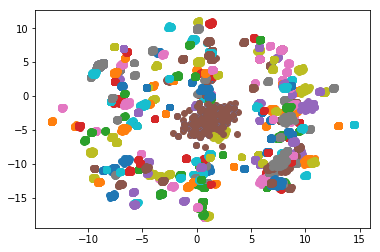

Most and least certain item:


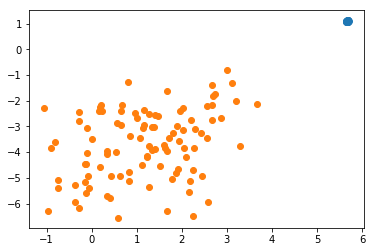

In [10]:
print("Random items:")
items = torch.randint(low=1, high=len(ind2val['itemId']), size = (300,))
plot_distr_of_items(items)
plt.show()
items = np.array([pyro.param("item_var_factor").argmin().item(), pyro.param("item_var_factor").argmax().item()])
print("Most and least certain item:")
plot_distr_of_items(items)